## New York CitiBike Bike Availability Predictor

### Exploratory Data Analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta 
import scipy.optimize as optimization
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

### Load Historical Trip Data from Jan - Jun 2020

In [2]:
# import raw data
tripsData= pd.read_csv('combined_citiBikeData_2020.csv', index_col = None)


In [3]:
tripsData.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,Start Day,Start Time,Stop Day,Stop Time,Age,Gender,distance
0,122,2020-06-01 00:02:21.750,2020-06-01 00:04:24.325,3792,Columbus Dr at Exchange Pl,40.716870,-74.032810,3639,Harborside,40.719252,...,42489,Subscriber,1987,2020-06-01,00:02:21.750000,2020-06-01,00:04:24.325000,33,Male,NaN
1,1282,2020-06-01 00:12:27.109,2020-06-01 00:33:50.054,3198,Heights Elevator,40.748716,-74.040443,3276,Marin Light Rail,40.714584,...,42183,Subscriber,1988,2020-06-01,00:12:27.109000,2020-06-01,00:33:50.054000,32,Male,NaN
2,186,2020-06-01 01:19:59.209,2020-06-01 01:23:05.893,3275,Columbus Drive,40.718355,-74.038914,3681,Grand St,40.715178,...,42140,Subscriber,1987,2020-06-01,01:19:59.209000,2020-06-01,01:23:05.893000,33,Male,NaN
3,131,2020-06-01 01:26:42.205,2020-06-01 01:28:53.804,3267,Morris Canal,40.712419,-74.038526,3681,Grand St,40.715178,...,42120,Subscriber,1987,2020-06-01,01:26:42.205000,2020-06-01,01:28:53.804000,33,Male,NaN
4,266,2020-06-01 01:27:33.709,2020-06-01 01:32:00.189,3639,Harborside,40.719252,-74.034234,3186,Grove St PATH,40.719586,...,42437,Subscriber,1972,2020-06-01,01:27:33.709000,2020-06-01,01:32:00.189000,48,Female,NaN


### Clean Data 

In [4]:
# drop unnecessary columns
tripsData_df = tripsData.drop(
    ['start station name', 'end station name','Gender','birth year',
    'Age','Start Time','Stop Time','distance','Stop Day','stoptime'], axis=1)
tripsData_df.head()

,tripduration,starttime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,Start Day
0,122,2020-06-01 00:02:21.750,3792,40.716870,-74.032810,3639,40.719252,-74.034234,42489,Subscriber,2020-06-01
1,1282,2020-06-01 00:12:27.109,3198,40.748716,-74.040443,3276,40.714584,-74.042817,42183,Subscriber,2020-06-01
2,186,2020-06-01 01:19:59.209,3275,40.718355,-74.038914,3681,40.715178,-74.037683,42140,Subscriber,2020-06-01
3,131,2020-06-01 01:26:42.205,3267,40.712419,-74.038526,3681,40.715178,-74.037683,42120,Subscriber,2020-06-01
4,266,2020-06-01 01:27:33.709,3639,40.719252,-74.034234,3186,40.719586,-74.043117,42437,Subscriber,2020-06-01


In [6]:
# convert starttime and stoptime to datetime objects
from datetime import datetime

tripsData_df.starttime = tripsData_df.starttime.apply(pd.to_datetime)

In [7]:
tripsData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36921 entries, 0 to 36920
Data columns (total 11 columns):
tripduration               36921 non-null int64
starttime                  36921 non-null datetime64[ns]
start station id           36921 non-null int64
start station latitude     36921 non-null float64
start station longitude    36921 non-null float64
end station id             36921 non-null int64
end station latitude       36921 non-null float64
end station longitude      36921 non-null float64
bikeid                     36921 non-null int64
usertype                   36921 non-null object
Start Day                  36921 non-null object
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 3.1+ MB


In [8]:
# Pre processing train data
# Adding time and month to the dataframe using datatime column

import datetime

def get_month(dt):
    return dt.month

tripsData_df['month'] = tripsData_df['starttime'].map(get_month)

def get_week(dt):
    return dt.week

tripsData_df['week'] = tripsData_df['starttime'].map(get_week)

def get_dom(dt):
    return dt.day

tripsData_df['dom'] = tripsData_df['starttime'].map(get_dom)

# day of the week column
def get_weekday(dt):
    return dt.weekday()

tripsData_df['weekday'] = tripsData_df['starttime'].map(get_weekday)

# Hour of the day column
def get_hour(dt):
    return dt.hour

tripsData_df['hour'] = tripsData_df['starttime'].map(get_hour)

tripsData_df.tail()

,tripduration,starttime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,Start Day,month,week,dom,weekday,hour
36916,2828,2020-06-30 23:53:19.738,3199,40.728745,-74.032108,3199,40.728745,-74.032108,18351,Customer,2020-06-30,6,27,30,1,23
36917,2729,2020-06-30 23:54:44.010,3199,40.728745,-74.032108,3199,40.728745,-74.032108,44401,Customer,2020-06-30,6,27,30,1,23
36918,2788,2020-06-30 23:54:52.192,3199,40.728745,-74.032108,3199,40.728745,-74.032108,42334,Customer,2020-06-30,6,27,30,1,23
36919,2702,2020-06-30 23:56:14.665,3199,40.728745,-74.032108,3199,40.728745,-74.032108,42463,Customer,2020-06-30,6,27,30,1,23
36920,2649,2020-06-30 23:57:46.149,3199,40.728745,-74.032108,3199,40.728745,-74.032108,42468,Customer,2020-06-30,6,27,30,1,23


### Trend Historical Data

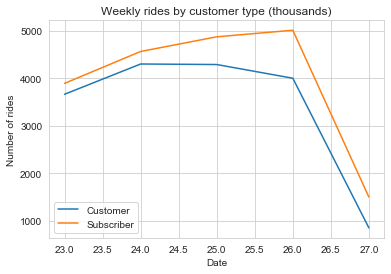

In [30]:
# Weekly ridership by subscription model
t = tripsData_df.groupby([tripsData_df['week'], 'usertype']).size()
t = t.unstack('usertype')

sns.set_style("whitegrid")
_ = plt.plot(t)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of rides')
_ = plt.title('Weekly rides by customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])

#save image as png
plt.savefig('images/wklyRidership.png')
plt.show()

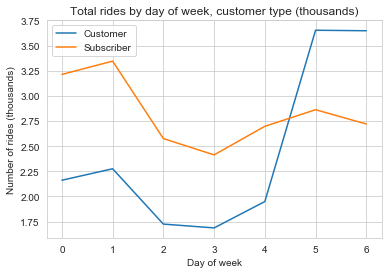

In [33]:
# Daily ridership by subscription model
t = tripsData_df.groupby(['weekday', 'usertype']).size()
t = t.unstack('usertype')

sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Day of week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Total rides by day of week, customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])

#save image as png
plt.savefig('images/dailyRidership.png')
plt.show()

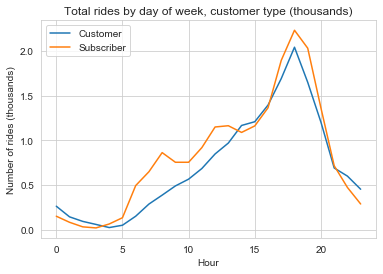

In [32]:
# Hourly ridership by subscription model
t = tripsData_df.groupby(['hour', 'usertype']).size()
t = t.unstack('usertype')

sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Hour')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Total rides by day of week, customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])

#save image as png
plt.savefig('images/hourlyRidership.png')
plt.show()


### Trend Real-Time Data

In [34]:
# Load data 
bikeAvailability= pd.read_csv('bikeStatus_data.csv', index_col = None)
bikeAvailability.head()

,bikes_available,bikes_disabled,docks_available,docks_disabled,station_id,datetime,timestamp,dom,weekday,hour,availability
0,22,3,30,0,72,2020-08-01 03:23:00,1.314641e+09,1,5,3,1
1,26,1,6,0,79,2020-08-01 03:29:00,1.314641e+09,1,5,3,1
2,22,4,1,0,82,2020-08-01 03:31:00,1.314641e+09,1,5,3,1
3,37,1,24,0,83,2020-08-01 03:30:00,1.314641e+09,1,5,3,1
4,39,3,8,0,116,2020-08-01 03:27:00,1.314641e+09,1,5,3,1


In [35]:
%pylab inline
import pandas
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [39]:
# Group data by dom for easier data manipulation and visualization
#for r, rows in bikeStatus_df.groupby('dom'):
#    print((r, len(rows)))
 
def count_rows(rows):
    return len(rows)

by_date = bikeAvailability.groupby('dom').apply(count_rows)
by_date

dom
1       7890
2        935
3      27652
4      10459
5     147863
6     145752
7      59375
30       302
31      3534
dtype: int64

Text(0.5, 1.0, 'Frequency by DoM - NY CitiBike 2020')

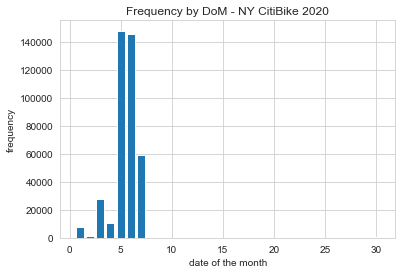

In [40]:
# DOM histogram

hist(bikeAvailability.dom, bins=30, rwidth=.8, range=(0.5, 30.5))
xlabel('date of the month')
ylabel('frequency')
title('Frequency by DoM - NY CitiBike 2020')

(array([21322.,  8975., 13577., 17021., 18345., 18020., 17560., 17674.,
        15397., 17213., 16585., 13462., 14079., 16051., 16540., 16576.,
        18396., 15916., 15292., 15033., 13952., 19026., 24458.,     0.]),
 array([ 0.5       ,  1.47916667,  2.45833333,  3.4375    ,  4.41666667,
         5.39583333,  6.375     ,  7.35416667,  8.33333333,  9.3125    ,
        10.29166667, 11.27083333, 12.25      , 13.22916667, 14.20833333,
        15.1875    , 16.16666667, 17.14583333, 18.125     , 19.10416667,
        20.08333333, 21.0625    , 22.04166667, 23.02083333, 24.        ]),
 <a list of 24 Patch objects>)

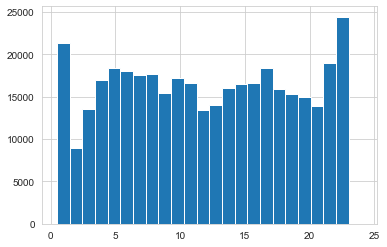

In [41]:
# Hour histogram
hist(bikeAvailability.hour, bins=24, range=(.5, 24))

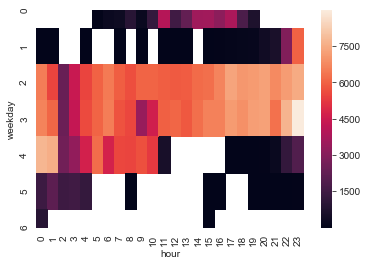

In [43]:
#  cross analysis (hour, dow) heatmap
by_cross = bikeAvailability.groupby('weekday hour'.split()).apply(count_rows).unstack()
seaborn.heatmap(by_cross)

### Scatter Matrix (Paired Scatter Plots)

Shows an overview of how the different variables are correlated and their distribution.

There seems to be no correlation among the variables, reducing the effects of colinearity in our models.

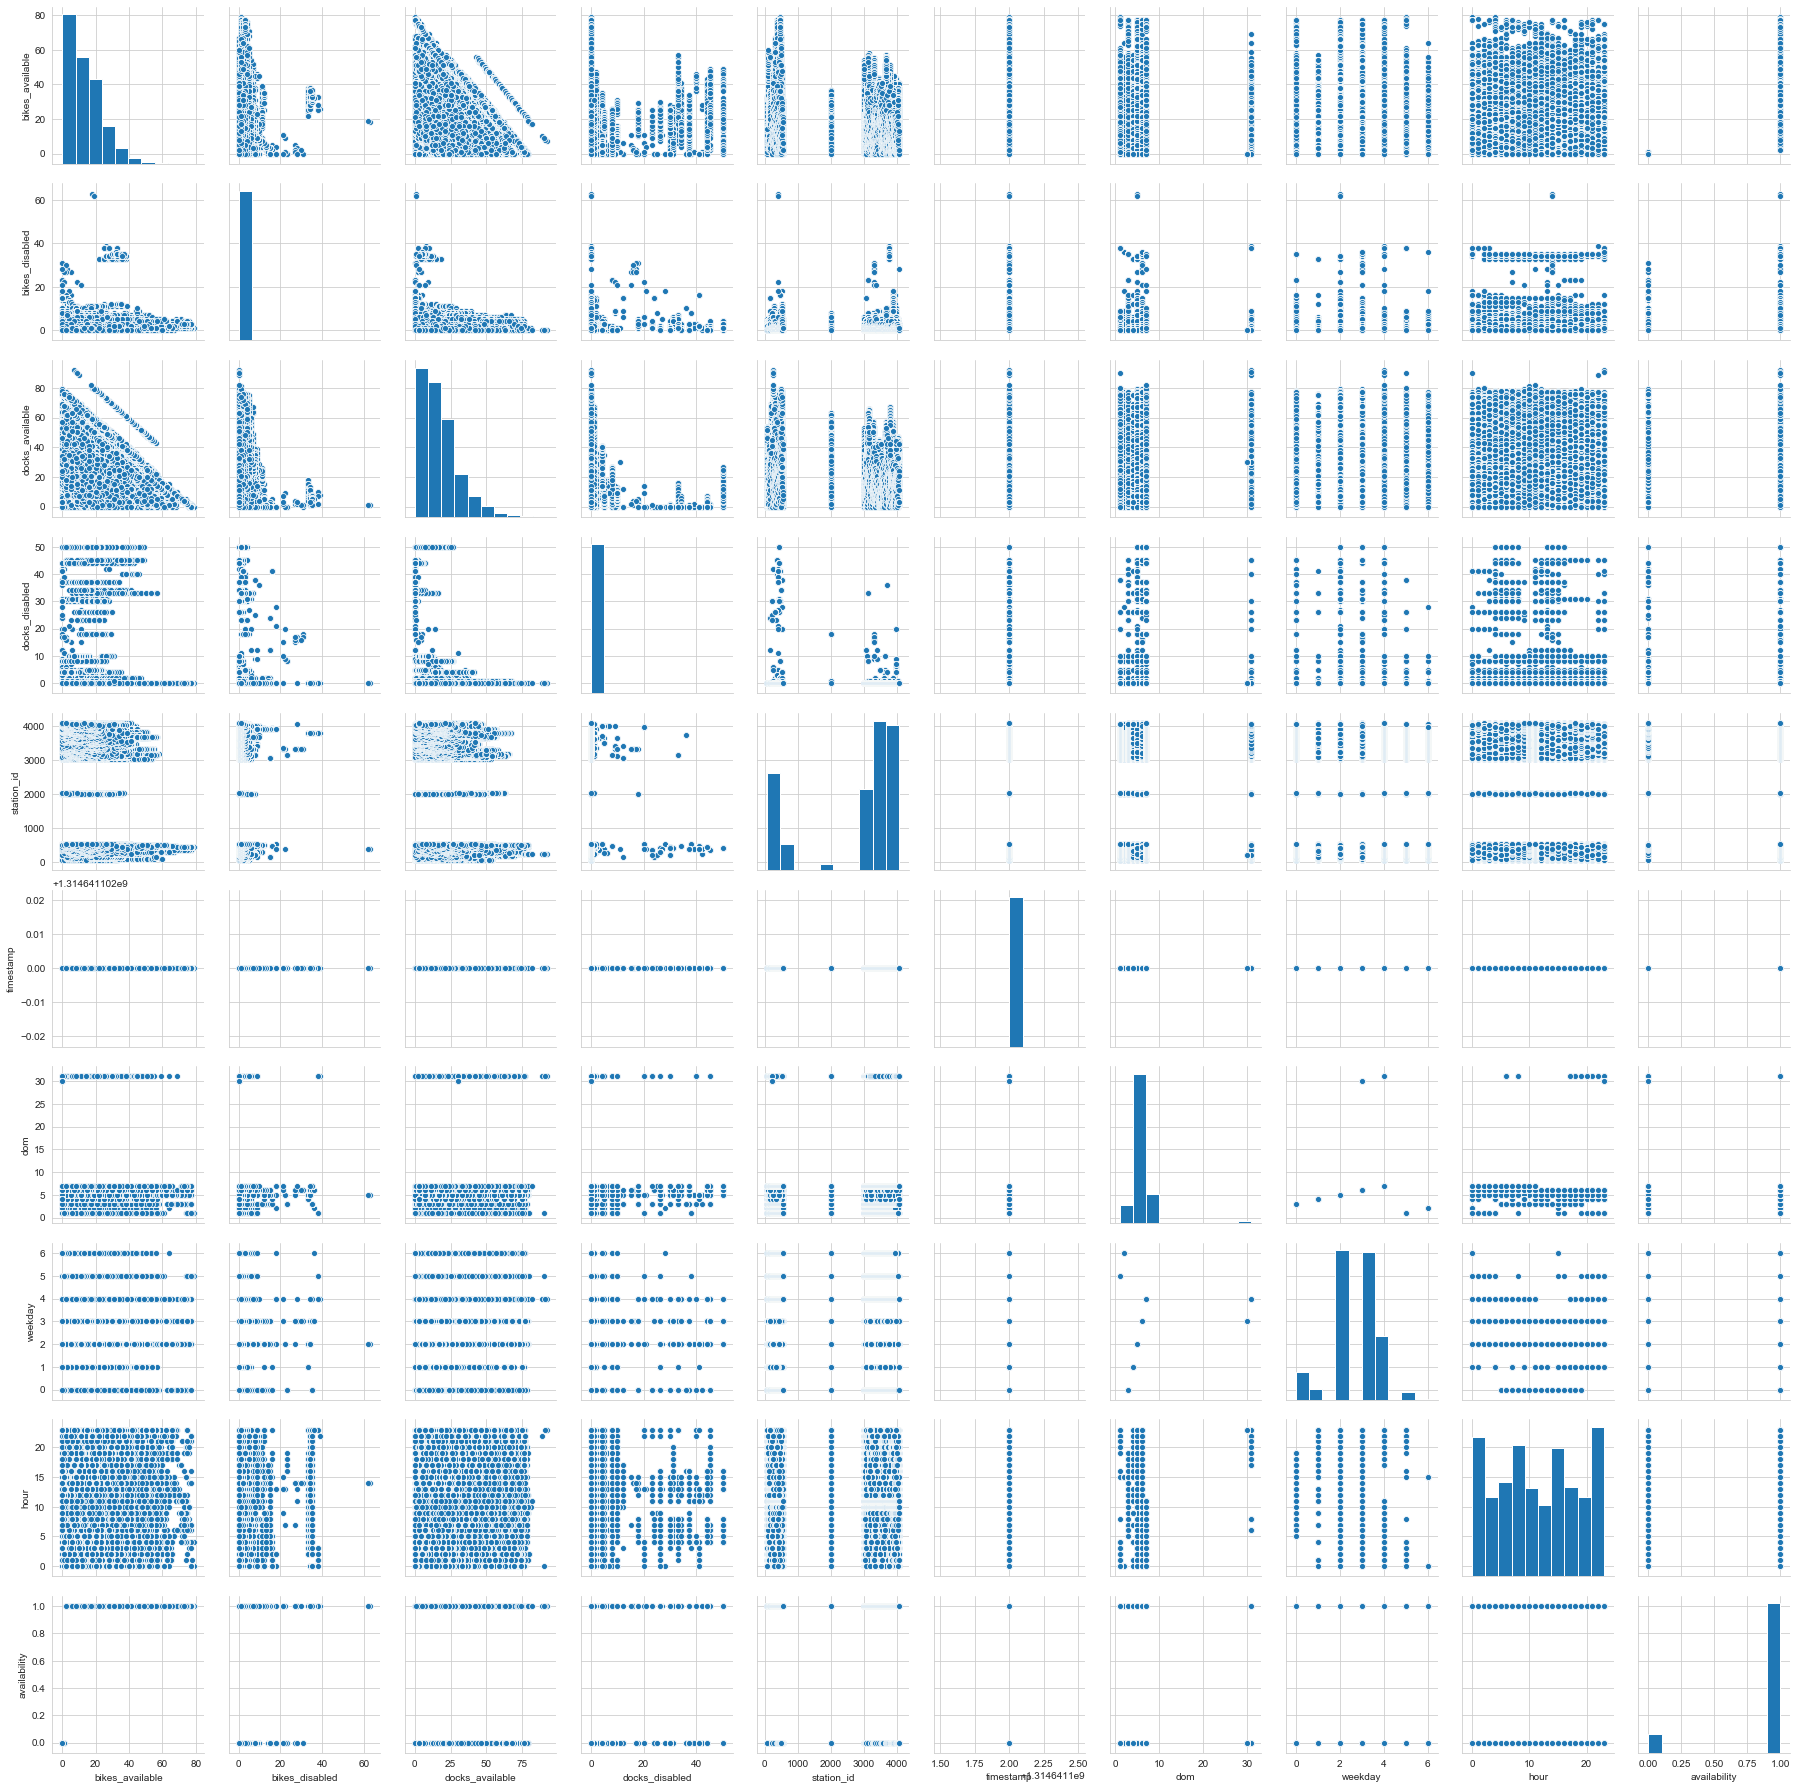

In [44]:
sns.pairplot(bikeAvailability)

#save image as png
plt.savefig('images/bikePairplt.png')